In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0
#data.images[:,0:392] = (data.images[:,0:392]-.5)*2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
for i in range(14):
    for j in range(14):
        data.images[:,i*14+j] = data.images[:,56*i+2*j] 

In [3]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
#    m = np.mean(np.reshape(m,[-1,10]),1)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, label=label, linewidth=3)
#    ax.fill_between(np.arange(1, len(m)+1), m-s, m+s, color=line.get_color(), alpha=0.075)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def jacobian(y_flat, x):
    n = y_flat.shape[0]
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float32, size=n),
    ]
    _, jacobian = tf.while_loop(
        lambda j, _: j < n,
        lambda j, result: (j+1, result.write(j, tf.gradients(y_flat[j], x))),
        loop_vars)
    return tf.squeeze(jacobian.stack())

### Graph

In [4]:
def get_weights(wn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        return tf.get_variable(wn)

def add_layer(inputs, wn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [out_dim, in_dim+1], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
    inputs = tf.concat([inputs, tf.ones([tf.shape(inputs)[0],1])], 1)
    ww = tf.transpose(w)
    return tf.matmul(inputs, ww) if af is None else af(tf.matmul(inputs, ww))


likelihood_ratio = lambda f, p, s, w: opt.compute_gradients(tf.reduce_mean(
                                          tf.stop_gradient(f)*log_prob(p,s), 0), w)
prob = lambda p, s: tf.pow(p+eps,s)*tf.pow(1-p+eps,1-s)
log_prob = lambda p, s: tf.log(prob(p,s))

ts = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)

eps = 1e-7
#dim = 392
dim = 98
nn = 50
batch = 24
ns = 1

y_ = tf.placeholder(tf.float32, [batch, dim])
x = tf.placeholder(tf.float32, [batch, dim])

h = add_layer(x, "wxh", dim, nn, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns),[-1,nn]))
h2 = add_layer(sh, "whh", nn, nn, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns),[-1,nn]))
y = add_layer(sh2, "why", nn, dim, tf.nn.sigmoid)

In [5]:
y = -log_prob(y, tf.tile(y_,[ns**2,1]))
nll = tf.reduce_mean(tf.reduce_sum(y,1))
yx = tf.reduce_mean(tf.reshape(y,[ns,-1,dim]),0)

# multi-sample objective
#y = prob(y, tf.tile(y_,[ns**2,1]))
#nll = tf.reduce_mean(tf.reduce_sum(-tf.log(tf.reduce_mean(tf.reshape(y,[ns**2,batch,dim]),0)+eps),1))
#dnll = -1/(tf.reduce_mean(tf.reshape(y,[ns**2,batch,dim]),0)+eps)

In [6]:
lr = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)
dy = opt.compute_gradients(nll, get_weights("why")) 
dh = likelihood_ratio(tf.reduce_sum(y,1,keep_dims=True), h2, sh2, get_weights("whh"))
dx = likelihood_ratio(tf.reduce_sum(y,1,keep_dims=True), h, sh, get_weights("wxh"))

gd = [list(i) for i in dy]+[list(i) for i in dh]+[list(i) for i in dx]
for i in range(3):
    gd[i][0] = tf.check_numerics(gd[i][0], str(i))
gdn = (tf.norm(gd[2][0])+tf.norm(gd[1][0]))/2.
train = tf.cond(reinforce, lambda: opt.apply_gradients(gd), lambda: opt.minimize(nll))

### muProp

In [ ]:
def muProp(p, s, layer, wx, wh, wy):
    p_ = tf.concat([p, tf.ones([tf.shape(p)[0],1])], 1)
    if layer==1:
        p_ = tf.nn.sigmoid(tf.matmul(p_,tf.transpose(wh)))
        p_ = tf.concat([p_, tf.ones([tf.shape(p_)[0],1])], 1)
    z = tf.nn.sigmoid(tf.matmul(p_,tf.transpose(wy)))
    z = -log_prob(z, tf.tile(y_,[ns**(layer-1),1]))
#    z = tf.stop_gradient(tf.tile(dnll,[ns**(layer-1),1]))*prob(z, tf.tile(y_,[ns**(layer-1),1]))
    z = tf.reduce_sum(z,1,keep_dims=True)
    
    dfh = tf.gradients(z,p)[0]
    g = z + tf.reduce_sum(dfh*(s-p),1,keep_dims=True)
    w = wx if layer==1 else wh
    mg = tf.stop_gradient(dfh)*p    
    dmg = tf.gradients(tf.reduce_mean(mg, 0), w)[0]
    return g, dmg


cvh = muProp(h2, sh2, 2, get_weights("wxh"), get_weights("whh"), get_weights("why"))
cvx = muProp(h, sh, 1, get_weights("wxh"), get_weights("whh"), get_weights("why"))

mdh = likelihood_ratio(tf.reduce_sum(y,1,keep_dims=True)-cvh[0], h2, sh2, get_weights("whh"))
mdx = likelihood_ratio(tf.reduce_sum(yx,1,keep_dims=True)-cvx[0], h, sh, get_weights("wxh"))

#dnlly = tf.tile(dnll,[ns**2,1])*y
#mdh = likelihood_ratio(tf.reduce_sum(dnlly,1,keep_dims=True)-cvh[0], h2, sh2, get_weights("whh"))
#mdx = likelihood_ratio(tf.reduce_sum(tf.reduce_mean(tf.reshape(dnlly,[ns,-1,dim]),0),
#                                     1,keep_dims=True)-cvx[0], h, sh, get_weights("wxh"))

mpgd = [list(i) for i in dy]+[list(i) for i in mdh]+[list(i) for i in mdx]
mpgd[1][0] += cvh[1]
mpgd[2][0] += cvx[1]
for i in range(3):
    mpgd[i][0] = tf.check_numerics(mpgd[i][0], str(i))
mpgdn = (tf.norm(mpgd[2][0])+tf.norm(mpgd[1][0]))/2.
mp_train = opt.apply_gradients(mpgd)

### NVIL

In [184]:
baseline = tf.placeholder(tf.float32)

def idb(z, w, n, f):
    s1 = add_layer(z, w+"_", n, nn, tf.nn.tanh)
    s2 = add_layer(s1, w, nn, 1)
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.stop_gradient(f)-s2),1))
    return loss, s2

bs = tf.cond(ts<1, lambda: tf.reduce_mean(y),
                   lambda: .999*baseline + .001*tf.reduce_mean(y))

bx = idb(x, "widbx", dim, y-bs)
bh = idb(sh, "widbh", nn, y-bs)

bdh = likelihood_ratio(tf.reduce_sum(y-bs-bh[1],1,keep_dims=True), h2, sh2, get_weights("whh"))
bdx = likelihood_ratio(tf.reduce_sum(y-bs-bx[1],1,keep_dims=True), h, sh, get_weights("wxh"))

bgd = [list(i) for i in dy]+[list(i) for i in bdh]+[list(i) for i in bdx]
for i in range(3):
    bgd[i][0] = tf.check_numerics(bgd[i][0], str(i))
bgdn = (tf.norm(bgd[2][0])+tf.norm(bgd[1][0]))/2.
btrain = opt.apply_gradients(bgd)

optt = tf.train.AdamOptimizer(lr*10, beta2=.99999)
ibtrain = optt.minimize(bx[0]+bh[0])

### REBAR

### Biased estimator

In [7]:
def straight_through(p):
    stsh = tf.stop_gradient(tf.reshape(Bernoulli(probs=p,dtype=tf.float32).sample(ns),[-1,nn])-p)+p
    p2 = add_layer(stsh, "whh", nn, nn, tf.nn.sigmoid)
    stsh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=p2,dtype=tf.float32).sample(ns),[-1,nn])-p2)+p2
    sty = -log_prob(add_layer(stsh2, "why", nn, dim, tf.nn.sigmoid), tf.tile(y_,[ns**2,1]))
    return tf.reduce_mean(tf.reduce_sum(sty,1))

sttrain = opt.minimize(straight_through(h))


def Gumbel_dist(p):
    g0 = -tf.log(-tf.log(tf.random_uniform(tf.shape(p))))
    g1 = -tf.log(-tf.log(tf.random_uniform(tf.shape(p))))
    u1 = tf.exp((tf.log(p+eps)+g1)/tau)
    u0 = tf.exp((tf.log(1-p+eps)+g0)/tau)
    return u1/(u0+u1+eps)

def Gumbel(p):
    stsh = Gumbel_dist(p)
    p2 = add_layer(stsh, "whh", nn, nn, tf.nn.sigmoid)
    stsh2 = Gumbel_dist(p2)
    sty = -log_prob(add_layer(stsh2, "why", nn, dim, tf.nn.sigmoid), tf.tile(y_,[ns**2,1]))
    return tf.reduce_mean(tf.reduce_sum(sty,1))

gbtrain = opt.minimize(Gumbel(h))

### Train

In [15]:
def fit_model(steps, filename):
    loss_rec = np.empty((1000, steps/1000))
    gd_rec = np.empty((1000, steps/1000))
    _lr = 3e-4
    _tau = 1
    _bs = 0.
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())            
        for i in range(steps):
            batch_   = data.next_batch(24, shuffle=True)[0]
            batch_xs = batch_[:, 0:dim]
            batch_ys = batch_[:, dim:2*dim]
            
            res = sess.run([nll,
#                            gdn, train],
#                            mpgdn, mp_train],
#                            bgdn, btrain, ibtrain, bs],
#                            gbtrain],
                            retrain],
                            {x: batch_xs, y_: batch_ys, lr: _lr, ts:i, tau:_tau,
#                             baseline: _bs, 
                           })                
#            _bs = res[-1]

            if (i+1)%50000==0 and _lr>1e-5:
                _lr /= 2.
            if (i+1)%50000==0 and _tau>.1:            
                _tau /= 2.
                
            loss_rec[i%1000, i/1000], gd_rec[i%1000, i/1000] = res[0], res[1]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0),

    np.save(filename, [loss_rec, gd_rec]) 
    return loss_rec, gd_rec, batch_xs, batch_ys, res[1]

In [16]:
test0 = fit_model(200000, "testGB")

1 85.1931525116 2 37.0079709969 3 30.8889741325 4 29.2643029575 5 28.8232620354 6 28.6470159035 7 28.5983409595 8 28.5760837955 9 28.5524344559 10 28.5642695866 11 28.3211399803 12 27.9100244007 13 27.5858862915 14 27.2605933056 15 27.0126775894 16 26.6887268276 17 26.4882860126 18 26.3269439602 19 26.1459158154 20 25.9663498325 21 25.8225668449 22 25.6887855396 23 25.5403409538 24 25.4298279495 25 25.3423433113 26 25.2322600422 27 25.1430352516 28 25.0821149292 29 24.942521244 30 24.9160712776 31 24.8301703529 32 24.8112124138 33 24.7661134224 34 24.6776821079 35 24.6260153637 36 24.5591216469 37 24.4875038452 38 24.467160677 39 24.4261938076 40 24.335731739 41 24.372785881 42 24.3252127075 43 24.2422559071 44 24.2596995449 45 24.1839357033 46 24.1708813934 47 24.1377755833 48 24.1000518742 49 24.0774711857 50 24.0395582809 51 23.9115918407 52 23.916208622 53 23.8374834347 54 23.8584476891 55 23.8422804108 56 23.7244538269 57 23.8139757805 58 23.755732523 59 23.7791515007 60 23.801349

KeyboardInterrupt: 

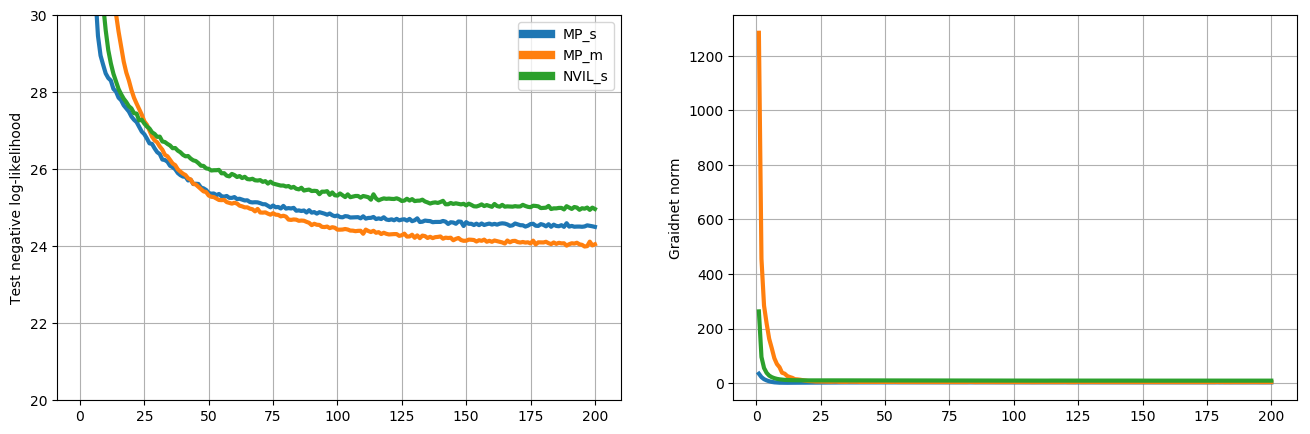

In [187]:
plt.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].set_ylabel("Test negative log-likelihood")
ax[1].set_ylabel("Graidnet norm")

ax[0].set_ylim(20,30)
#ax[1].set_ylim(0,80)
for i in range(2):
#    ax[i].set_xlim(0,100)
#    ax[i].set_xlabel("Steps with the same # grads (1e4)")
#    ax[i].set_xlabel("Steps (1e4)")

    plot_banded_error(test0[i], "MP_s", ax[i])
    plot_banded_error(test1[i], "MP_m", ax[i])
    plot_banded_error(test2[i], "NVIL_s", ax[i])    

    


    fatlegend(ax[0])
    ax[i].grid(True)
plt.show()
#fig.savefig('nll2_2.png')

### SVRG

In [ ]:
_cch = tf.placeholder(tf.float32,[2,50,51])
_ccx = tf.placeholder(tf.float32,[2,50,393])
def ocoef(df, dg, _cov, _var):
#    mff = .99*mf + .01*df
    var_dg = tf.square(dg)
    cov = df*dg
    return 0.99*_cov+0.01*cov, 0.99*_var+0.01*var_dg

_wxh = tf.placeholder(tf.float32, [50,393])
_whh = tf.placeholder(tf.float32, [50,51])
_why = tf.placeholder(tf.float32, [392,51])
_dx = tf.placeholder(tf.float32, [50,393])
_dh = tf.placeholder(tf.float32, [50,51])

lh = tf.nn.sigmoid(tf.matmul(tf.concat([x,tf.ones([tf.shape(x)[0],1])],1), tf.transpose(_wxh)))
lh2 = tf.nn.sigmoid(tf.matmul(tf.concat([sh,tf.ones([tf.shape(sh)[0],1])],1), tf.transpose(_whh)))
ly  = prob(tf.nn.sigmoid(tf.matmul(tf.concat([sh2,tf.ones([tf.shape(sh2)[0],1])],1), tf.transpose(_why))),
           tf.tile(y_,[ns**2,1]))
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]
dlnll = tf.tile(-1/(ly_expect+eps), [ns**2,1])*ly
lls2 = tf.stop_gradient(tf.reduce_sum(dlnll,1,keep_dims=True))*log_prob(_lh2, sh2)
lls = tf.stop_gradient(tf.reduce_sum(tf.reduce_mean(tf.reshape(
                       dlnll,[ns,-1,392]),0),1,keep_dims=True))*log_prob(_lh, sh)

ldh = tf.gradients(tf.reduce_mean(lls2, 0), _whh)[0]
ldx = tf.gradients(tf.reduce_mean(lls, 0),_wxh)[0]

_cvh = muProp(lh2, sh2, 2, _wxh, _whh, _why)
_cvx = muProp(lh, sh, 1, _wxh, _whh, _why)

lcx = ocoef(dx[0][0],ldx,_ccx[0], _ccx[1])
lch = ocoef(dh[0][0],ldh,_cch[0], _cch[1])
_lcx = lcx[0]/(lcx[1]+eps)
_lch = lch[0]/(lch[1]+eps)

lgd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]

lgd[2][0] -= ldx-_dx+cvx[0]-_cvx[0]
lgd[1][0] -= ldh-_dh+cvh[0]-_cvh[0]

lgdn = (tf.norm(lgd[2][0])+tf.norm(lgd[1][0]))/2.
ltrain_step = opt.apply_gradients(lgd)

In [ ]:
#rl = .0001
rl = .01
#rl=1.

#kld = .00001
kld = .05
#kld=1.

nn = 4

ts = tf.placeholder(tf.float32)
nsvrg = tf.placeholder(tf.bool)
beta = .999
alpha = .9

fimx = tf.placeholder(tf.float32,[3,50,393])
fimh = tf.placeholder(tf.float32,[50,51,None])

djh = tf.placeholder(tf.float32,[50,51])
djy = tf.placeholder(tf.float32,[2,392,51])

def arrow_fisher(p, s, w, acc, g):
    J = tf.transpose(1/(eps+tf.sqrt(p*(1-p))))*tf.gradients(p,w)[0]
    dJ = beta*acc[0]+(1-beta)*tf.square(J)
    rJ = beta*acc[1]+(1-beta)*J*tf.expand_dims(J[:,-1], -1)
    u = tf.concat([rJ[:,0:-1]/(dJ[:,0:-1]+rl), -1*tf.ones([tf.shape(rJ)[0],1])],1)
    rho = tf.transpose([1./((1.-392.)*dJ[:,-1]+rl)])
    
    gg = alpha*acc[2] + (1-alpha)*g
    ng = tf.concat([gg[:,0:-1]/(dJ[:,0:-1]+rl), tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho
    
    ng = tf.check_numerics(ng/(1-tf.pow(alpha,ts+1))*(1-tf.pow(beta,ts+1)), "xx")
    ac = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
    return .01*ng, ac

def fisher(p, s, w, acc, g):
    f = tf.reshape(p,[nn,-1,50])
    gg = tf.transpose(tf.transpose(1./(tf.sqrt(f*(1-f))+eps),perm=[0,2,1])*jacobian(f,w),perm=[1,2,0])
    XX = tf.concat([np.sqrt(beta)*acc, np.sqrt(1-beta)*gg/2.], 2)
    FIM = tf.matmul(XX,tf.transpose(XX, perm=[0,2,1]))
    
    k,Xk = 5,1
    XX = tf.cond(tf.greater_equal(tf.shape(XX)[2], 100*Xk),
                 lambda: tf.transpose(tf.svd(FIM)[1][:,0:k,:]*tf.expand_dims(tf.sqrt(tf.svd(FIM)[0][:,0:k]),2),
                                      perm=[0,2,1]),
                 lambda: XX)
    
    FIM += tf.tile(tf.expand_dims(tf.diag(tf.ones([51])*rl),0),[50,1,1])    
    iFIM = tf.matrix_inverse(FIM/(1-tf.pow(beta,ts+1)))
    g = tf.expand_dims(g,2)
    ng = tf.check_numerics(tf.matmul(iFIM, g)/(1-tf.pow(alpha,ts+1)),"hh")

#    sz = tf.sqrt(2*kld/(eps+tf.matmul(tf.matmul(tf.transpose(g,perm=[0,2,1]), FIM), g)))
    return tf.squeeze(kld*ng), XX


ngd = [list(i) for i in dy] + [list(i) for i in dh] + [list(i) for i in dx]
hdj = alpha*djh+(1-alpha)*(ngd[1][0]-cvh[0]-ldh+_cvh[0]+_dh)
ngd[1][0], fmh = fisher(h2,sh2,get_weights("whh"),fimh, hdj/(1-tf.pow(alpha,ts+1)))

xdj = ngd[2][0]-cvx[0]-ldx+_cvx[0]+_dx
ngd[2][0], fmx = arrow_fisher(h, sh, get_weights("wxh"), fimx, xdj)

mvy = beta*djy[0]+(1-beta)*tf.square(ngd[0][0])
mgy = alpha*djy[1]+(1-alpha)*ngd[0][0]
ydj = tf.concat([[mvy],[mgy]],0)
ngd[0][0] = tf.check_numerics(mgy/(tf.sqrt(mvy)+eps)*(1-tf.pow(beta,ts+1))/(1-tf.pow(alpha,ts+1)), "yy")

ngdn = (tf.norm(ngd[2][0])+tf.norm(ngd[1][0]))/2.
ntrain_step = opt.apply_gradients(ngd)

In [ ]:
batch_xs = ngd_svrg[2]
batch_ys = ngd_svrg[3]
prdt = ngd_svrg[4]
bs = 1

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[7,14]) for i in batch_xs]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[7,14]) for i in batch_ys]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), 1, 1), 0)
#dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in prdt]], 1)
#p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), bs, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
#ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
#ax[1].grid(False)
plt.show()